<img src="OC.png" width="50" height="50" align="left">    

***

<center> <font size="6"> <span style='color:Blue'> P6: Classifiez automatiquement des biens de consommation </span></font> </center>  

***

<font size="3"> <span style="font-size: 1.5em" > **Partie 1 - 3/3: Etude de faisabilité via les données textuelles et images** </span> </font>  

**Contexte**  
**Place de marché** est une entreprise qui propose souhaite lancer une marketplace e-commerce.
<img src="PlaceDeMarche.png" width="400" height="200">
**Mission**   
* **Partie 1:**  
Réaliser une première **étude de faisabilité** de regroupement des produits de même catégorie via les descriptions ;
    * **1. textuelle** 
    * **2. image**  
    * **3. textuelle et image**
de ces produits.
* **Partie 2:**  
Réaliser une **classification supervisée** à partir des images;
    * **1. avec data augmentation**  
    * **2. avec des techniques recentes**

Dans ce notebook, nous étudions la faisabilité d'automatiser la catégorisation des produits en utilisant les données textuelles et images des produits. 

# Importation des données et des librairies Python pour DS

In [1]:
import os
import csv

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
from sklearn import manifold
from sklearn import cluster, metrics

In [2]:
df_text = pd.read_csv('./data/Traited/df_use.csv')
df_image = pd.read_csv('./data/Traited/df_vgg16_.csv')

In [3]:
print(df_text.shape)
df_text.head(2)

(1050, 513)


,uniq_id,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,55b85ea15a1536d46b7190ad6fff8ce7,0.056465,-0.016699,-0.037086,0.043791,0.002945,0.067963,-0.016188,0.046416,0.033914,...,-0.057716,-0.015940,-0.017477,0.069993,0.053311,-0.006422,0.019230,-0.013060,0.049839,0.063842
1,7b72c92c2f6c40268628ec5f14c6d590,0.005994,0.054335,-0.008692,0.028411,0.077500,0.083581,0.034467,-0.015866,-0.013572,...,0.064480,-0.043876,-0.055092,-0.053607,-0.018392,-0.045410,-0.046664,-0.002589,0.068149,0.025688


In [4]:
print(df_image.shape)
df_image.head(2)

(1050, 4097)


,uniq_id,0,1,2,3,4,5,6,7,8,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,55b85ea15a1536d46b7190ad6fff8ce7,3.398614,0.859572,0.0,1.106560,2.266122,2.927241,2.446448,0.0,0.0,...,0.485876,0.0,0.0,0.472938,0.875756,0.783684,0.0,0.0,0.851055,0.0
1,7b72c92c2f6c40268628ec5f14c6d590,0.000000,0.000000,0.0,1.172009,0.000000,0.000000,0.000000,0.0,0.0,...,1.169696,0.0,0.0,0.000000,0.000000,3.152507,0.0,0.0,0.000000,0.0


# Préparation des données

## Jointure des features image et texte

In [5]:
df_text_image = df_text.merge(df_image, left_on='uniq_id', right_on='uniq_id', how='outer')
print(df_text_image.shape)
df_text_image.head(2)

(1050, 4609)


,uniq_id,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,55b85ea15a1536d46b7190ad6fff8ce7,0.056465,-0.016699,-0.037086,0.043791,0.002945,0.067963,-0.016188,0.046416,0.033914,...,0.485876,0.0,0.0,0.472938,0.875756,0.783684,0.0,0.0,0.851055,0.0
1,7b72c92c2f6c40268628ec5f14c6d590,0.005994,0.054335,-0.008692,0.028411,0.077500,0.083581,0.034467,-0.015866,-0.013572,...,1.169696,0.0,0.0,0.000000,0.000000,3.152507,0.0,0.0,0.000000,0.0


In [6]:
df_text_image.index = df_text_image.uniq_id

In [7]:
df_text_image = df_text_image.drop(columns='uniq_id')

In [8]:
df_text_image

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
uniq_id,,,,,,,,,,,,,,,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,0.056465,-0.016699,-0.037086,0.043791,0.002945,0.067963,-0.016188,0.046416,0.033914,0.019882,...,0.485876,0.0,0.000000,0.472938,0.875756,0.783684,0.000000,0.000000,0.851055,0.000000
7b72c92c2f6c40268628ec5f14c6d590,0.005994,0.054335,-0.008692,0.028411,0.077500,0.083581,0.034467,-0.015866,-0.013572,0.062917,...,1.169696,0.0,0.000000,0.000000,0.000000,3.152507,0.000000,0.000000,0.000000,0.000000
64d5d4a258243731dc7bbb1eef49ad74,0.025071,0.002592,-0.004260,0.015883,0.065168,0.011295,0.043309,0.011210,0.024398,0.050517,...,0.000000,0.0,0.000000,0.000000,0.000000,5.270284,0.000000,1.297100,0.000000,0.000000
d4684dcdc759dd9cdf41504698d737d8,-0.056970,-0.036166,0.026730,0.055229,0.066253,-0.000522,-0.050997,-0.042714,0.026418,-0.004167,...,0.000000,0.0,0.000000,0.000000,0.000000,3.977747,0.000000,0.000000,0.000000,0.000000
6325b6870c54cd47be6ebfbffa620ec7,-0.022603,-0.025289,0.010708,-0.007875,0.067033,-0.003882,0.005227,-0.019191,0.055142,0.002674,...,0.000000,0.0,0.000000,0.000000,0.000000,9.195916,0.139736,0.000000,1.735950,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958f54f4c46b53c8a0a9b8167d9140bc,0.009871,-0.007065,-0.035278,0.033470,0.022877,-0.027113,-0.073660,0.027621,0.006366,0.008326,...,0.000000,0.0,0.058723,0.000000,0.000000,0.000000,0.859425,1.085387,0.000000,0.000000
fd6cbcc22efb6b761bd564c28928483c,0.029964,0.055782,0.051551,0.051615,0.030079,-0.010447,-0.070936,0.044204,-0.015268,-0.064188,...,0.000000,0.0,0.837411,0.839075,0.000000,1.042110,0.000000,1.560315,0.000000,0.998342
5912e037d12774bb73a2048f35a00009,0.054886,0.054627,0.031377,0.043513,-0.031930,0.012234,-0.082167,0.047591,-0.060990,-0.011750,...,1.230694,0.0,0.000000,0.000000,0.000000,0.193308,0.546066,2.159872,0.184722,0.000000


## PCA

In [16]:
scaler = StandardScaler()
df_text_image_std = scaler.fit_transform(df_text_image)

In [12]:
data = pd.read_csv('./data/Traited/data_categories_image.csv')
data.head()

,uniq_id,image_path,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7,./data/Images/55b85ea15a1536d46b7190ad6fff8ce7...,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,./data/Images/7b72c92c2f6c40268628ec5f14c6d590...,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,./data/Images/64d5d4a258243731dc7bbb1eef49ad74...,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,./data/Images/d4684dcdc759dd9cdf41504698d737d8...,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,./data/Images/6325b6870c54cd47be6ebfbffa620ec7...,Home Furnishing,4


In [13]:
y_cat_num = data["label"]
data['label_name'] = data['label_name'].astype('category')
l_cat = list(data['label_name'].cat.categories)

# Fontions utiles

In [14]:
def ARI_fct(features, y_cat_num):
    """
    Calcul Tsne, détermination des clusters et
    calcul ARI entre vrais catégorie et n° de clusters
    """

    time1 = time.time()
    num_labels = 7  # On dispose de 7 catégories
    # Projection 2 dimensions
    tsne = manifold.TSNE(n_components=2,
                         perplexity=30,
                         n_iter=2000,
                         init='random',
                         learning_rate=200,
                         random_state=42)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=num_labels,
                         n_init=100,
                         random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_

In [15]:
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat):
    """
    Visualisation du Tsne selon les vraies catégories et selon les clusters
    """
    fig = plt.figure(figsize=(15, 6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0],
                         X_tsne[:, 1],
                         c=y_cat_num,
                         cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0],
              labels=l_cat,
              loc="best",
              title="Categorie")
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0],
                         X_tsne[:, 1],
                         c=labels,
                         cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0],
              labels=set(labels),
              loc="best",
              title="Clusters")
    plt.title('Représentation des produits par clusters')

    plt.show()
    print("ARI : ", ARI)

# Méthode 1: étude de faisabilité avec les features images et textes 

In [17]:
print(df_text_image_std.shape)
pca = PCA(n_components=0.99, svd_solver='full')
feat_pca= pca.fit_transform(df_text_image_std)
print(feat_pca.shape)

(1050, 4608)
(1050, 869)


In [18]:
ARI, X_tsne, labels = ARI_fct(feat_pca,  y_cat_num)

ARI :  0.5402 time :  11.0


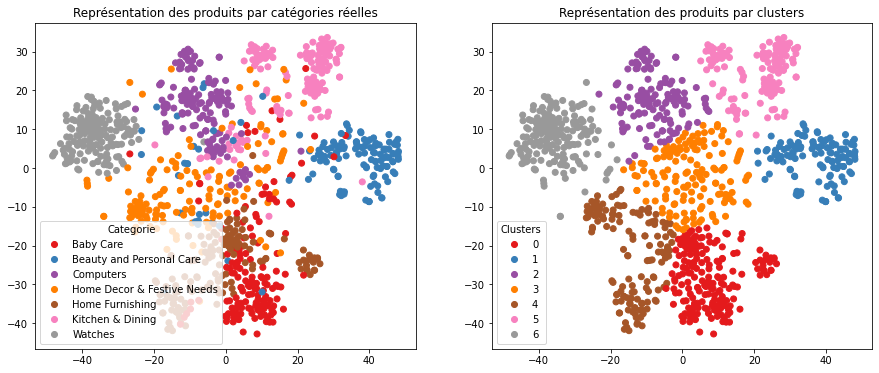

ARI :  0.5402


In [20]:
labels_ = pd.Series(labels).map(
    {0: 3, 1: 1, 2: 4, 3: 6, 4: 0, 5: 5, 6: 2}).values
TSNE_visu_fct(X_tsne, y_cat_num, labels_, ARI, l_cat)

# Conclusion

* ARI image = 0.46
* ARI texte = 0.69
* ARI image et text = 0.54
* Les données textuelles offrent le ARI le plus élevé. 